# Image Classification
In this project, you'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, you'll get to see your neural network's predictions on the sample images.
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

Ask yourself "What are all possible labels?", "What is the range of values for the image data?", "Are the labels in order or random?".  Answers to questions like these will help you preprocess the data and end up with better predictions.


Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 7:
Image - Min Value: 17 Max Value: 221
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


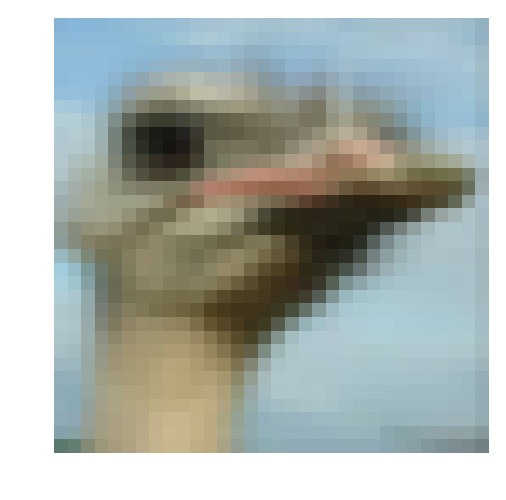

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 4
sample_id = 7
batch_size = 5
image_sizes = 32
image_channels = 3
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [3]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    x_min = np.min(x)
    return (x - x_min)/(np.max(x) - x_min)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_normalize(normalize)

Tests Passed


### One-hot encode
Just like the previous code cell, you'll be implementing a function for preprocessing.  This time, you'll implement the `one_hot_encode` function. The input, `x`, are a list of labels.  Implement the function to return the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`.  Make sure to save the map of encodings outside the function.

Hint: Don't reinvent the wheel.

In [4]:
import tensorflow as tf

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function
    encoder = tf.one_hot(x, 10)
    encodings = None
    with tf.Session() as sess:
        encodings = sess.run(encoder)
    return encodings

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_one_hot_encode(one_hot_encode)

Tests Passed


### Randomize Data
As you saw from exploring the data above, the order of the samples are randomized.  It doesn't hurt to randomize it again, but you don't need to for this dataset.

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
This is your first checkpoint.  If you ever decide to come back to this notebook or have to restart the notebook, you can start from here.  The preprocessed data has been saved to disk.

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, you'll build each layer into a function.  Most of the code you've seen has been outside of functions. To test your code more thoroughly, we require that you put each layer in a function.  This allows us to give you better feedback and test for simple mistakes using our unittests before you submit your project.

>**Note:** If you're finding it hard to dedicate enough time for this course each week, we've provided a small shortcut to this part of the project. In the next couple of problems, you'll have the option to use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages to build each layer, except the layers you build in the "Convolutional and Max Pooling Layer" section.  TF Layers is similar to Keras's and TFLearn's abstraction to layers, so it's easy to pickup.

>However, if you would like to get the most out of this course, try to solve all the problems _without_ using anything from the TF Layers packages. You **can** still use classes from other packages that happen to have the same name as ones you find in TF Layers! For example, instead of using the TF Layers version of the `conv2d` class, [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d), you would want to use the TF Neural Network version of `conv2d`, [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d). 

Let's begin!

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. Implement the following functions
* Implement `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

These names will be used at the end of the project to load your saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # TODO: Implement Function
    height, width, depth = image_shape
    return tf.placeholder(tf.float32, [None, height, width, depth], name='x')


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, [None, n_classes], name='y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, name='keep_prob')


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Activation Functions

In [8]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, you should implement the function `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.

**Note:** You **can't** use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for **this** layer, but you can still use TensorFlow's [Neural Network](https://www.tensorflow.org/api_docs/python/tf/nn) package. You may still use the shortcut option for all the **other** layers.

### Formula

$
h_{new} = \frac{h_{ori} - h_{k} + 2P}{s} + 1
$

In [9]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # TODO: Implement Function
    x_shape = x_tensor.get_shape().as_list()
    stddev = 2 / np.sqrt(x_shape[1] * x_shape[2] * x_shape[3])
    w_init = tf.truncated_normal([conv_ksize[0], conv_ksize[1], x_shape[3], conv_num_outputs], stddev=stddev)
    W = tf.Variable(w_init)
    b = tf.Variable(tf.zeros([conv_num_outputs]))
    conv = tf.nn.conv2d(x_tensor, W, strides=[1, conv_strides[0], conv_strides[1], 1], padding='SAME')
    conv = tf.nn.bias_add(conv, b)
    conv = selu(conv)
    pool = tf.nn.pool(conv, [pool_ksize[0], pool_ksize[1]], pooling_type='MAX', strides=[pool_strides[0], pool_strides[1]], padding='VALID')
    return pool


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer
Implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [10]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    tensor_shape = x_tensor.get_shape().as_list()
    return tf.reshape(x_tensor, [-1, tensor_shape[1]*tensor_shape[2]*tensor_shape[3]])


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
Implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [11]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    x_shape = x_tensor.get_shape().as_list()
    stddev = 2 / np.sqrt(x_shape[1])
    w_init = tf.truncated_normal([x_shape[1], num_outputs], stddev=stddev)
    W = tf.Variable(w_init)
    b = tf.Variable(tf.zeros([num_outputs]))
    logits = tf.nn.bias_add(tf.matmul(x_tensor, W), b)
    return selu(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

**Note:** Activation, softmax, or cross entropy should **not** be applied to this.

In [12]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    x_shape = x_tensor.get_shape().as_list()
    stddev = 2 / np.sqrt(x_shape[1])
    w_init = tf.truncated_normal([x_shape[1], num_outputs], stddev=stddev)
    W = tf.Variable(w_init)
    b = tf.Variable(tf.zeros([num_outputs]))
    return tf.nn.bias_add(tf.matmul(x_tensor, W), b)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_output(output)

Tests Passed


### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  Use the layers you created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

### Cost Functions

In [45]:
def future_cost_exp(cost, epoch):
    return tf.pow(cost*(1+(epoch+1)*tf.exp(-(epoch+1))-epoch*tf.exp(-epoch)), 2)

In [56]:
def future_cost_linear(cost, epoch):
    return tf.pow(2*cost+(1/4)*(tf.pow(epoch, 2)-tf.pow(epoch+1, 2)), 2)

In [75]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # TODO: Apply 1, 2, or 3 Convolution and Max Pool layers
    #    Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv_1 = conv2d_maxpool(x, 128, [3, 3], [1, 1], [2, 2], [2, 2])
    conv_2 = conv2d_maxpool(conv_1, 256, [3, 3], [1, 1], [1, 1], [1, 1])
    conv_out = tf.nn.dropout(conv_2, keep_prob)

    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    #   flatten(x_tensor)
    conv_flat = flatten(conv_out)

    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    fc_1 = fully_conn(conv_flat, 1024)
    fc_1_drop = tf.nn.dropout(fc_1, keep_prob)
    fc_out = fully_conn(fc_1_drop, 512)
    
    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    out = output(fc_out, 10)
    
    # TODO: return output
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
cost_epoch = tf.placeholder(tf.float32, name='cost_epoch')
cost_predict = future_cost_exp(cost, cost_epoch)
optimizer = tf.train.AdamOptimizer().minimize(cost_predict)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [48]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # TODO: Implement Function
    train_loss = session.run(cost, feed_dict={x:feature_batch, y:label_batch, keep_prob:1.})
    valid_loss = session.run(cost, feed_dict={x:valid_features, y:valid_labels, keep_prob:1.})
    train_accuracy = session.run(accuracy, feed_dict={x:feature_batch, y:label_batch, keep_prob:1.})
    valid_accuracy = session.run(accuracy, feed_dict={x:valid_features, y:valid_labels, keep_prob:1.})
    print('Loss = Train: {}, Valid: {}'.format(train_loss, valid_loss))
    print('Accuracy = Train: {} Valid: {}'.format(train_accuracy, valid_accuracy))

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

In [79]:
# TODO: Tune Parameters
epochs = 50
batch_size = 256
keep_probability = .5

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            sess.run([optimizer], feed_dict={x: batch_features, y: batch_labels, keep_prob: keep_probability, cost_epoch: epoch})
        
        print('Epoch {:>2}, CIFAR-10 Batch {}: \n'.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...


### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [77]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                sess.run([optimizer], feed_dict={x: batch_features, y: batch_labels, keep_prob: keep_probability, cost_epoch: epoch})
            print('Epoch {:>2}, CIFAR-10 Batch {}: \n'.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1: 
Loss = Train: 3.141954183578491, Valid: 3.507202625274658
Accuracy = Train: 0.17500001192092896 Valid: 0.18299999833106995
Epoch  1, CIFAR-10 Batch 2: 
Loss = Train: 1.9366474151611328, Valid: 2.074411392211914
Accuracy = Train: 0.42500001192092896 Valid: 0.3285999596118927
Epoch  1, CIFAR-10 Batch 3: 
Loss = Train: 1.7150108814239502, Valid: 1.8308324813842773
Accuracy = Train: 0.3999999761581421 Valid: 0.3741999566555023
Epoch  1, CIFAR-10 Batch 4: 
Loss = Train: 1.5369436740875244, Valid: 1.6893280744552612
Accuracy = Train: 0.42500001192092896 Valid: 0.421999990940094
Epoch  1, CIFAR-10 Batch 5: 
Loss = Train: 1.7899091243743896, Valid: 1.7496554851531982
Accuracy = Train: 0.4000000059604645 Valid: 0.4187999665737152
Epoch  2, CIFAR-10 Batch 1: 
Loss = Train: 1.6828938722610474, Valid: 1.5757174491882324
Accuracy = Train: 0.5000000596046448 Valid: 0.4519999623298645
Epoch  2, CIFAR-10 Batch 2: 
Loss = Train: 1.389458417892456, Valid: 1.53412

Epoch 12, CIFAR-10 Batch 1: 
Loss = Train: 0.7394480109214783, Valid: 1.0780600309371948
Accuracy = Train: 0.800000011920929 Valid: 0.6233999133110046
Epoch 12, CIFAR-10 Batch 2: 
Loss = Train: 0.5316076874732971, Valid: 1.1018285751342773
Accuracy = Train: 0.8750000596046448 Valid: 0.6147999167442322
Epoch 12, CIFAR-10 Batch 3: 
Loss = Train: 0.5454379320144653, Valid: 1.0977628231048584
Accuracy = Train: 0.7749999761581421 Valid: 0.6165999174118042
Epoch 12, CIFAR-10 Batch 4: 
Loss = Train: 0.631666362285614, Valid: 1.150433897972107
Accuracy = Train: 0.7749999761581421 Valid: 0.6061999201774597
Epoch 12, CIFAR-10 Batch 5: 
Loss = Train: 0.5187963247299194, Valid: 1.048606514930725
Accuracy = Train: 0.9249999523162842 Valid: 0.637799859046936
Epoch 13, CIFAR-10 Batch 1: 
Loss = Train: 0.7043607831001282, Valid: 1.0607781410217285
Accuracy = Train: 0.800000011920929 Valid: 0.6323999166488647
Epoch 13, CIFAR-10 Batch 2: 
Loss = Train: 0.4982413053512573, Valid: 1.1024723052978516
Accur

Epoch 23, CIFAR-10 Batch 1: 
Loss = Train: 0.36730629205703735, Valid: 1.0278770923614502
Accuracy = Train: 0.949999988079071 Valid: 0.6497999429702759
Epoch 23, CIFAR-10 Batch 2: 
Loss = Train: 0.2579675316810608, Valid: 1.0280221700668335
Accuracy = Train: 0.949999988079071 Valid: 0.6533998250961304
Epoch 23, CIFAR-10 Batch 3: 
Loss = Train: 0.3395272493362427, Valid: 1.0670428276062012
Accuracy = Train: 0.9000000357627869 Valid: 0.6497998833656311
Epoch 23, CIFAR-10 Batch 4: 
Loss = Train: 0.26603901386260986, Valid: 0.9984036087989807
Accuracy = Train: 0.9749999642372131 Valid: 0.6629998683929443
Epoch 23, CIFAR-10 Batch 5: 
Loss = Train: 0.30211341381073, Valid: 0.9962748885154724
Accuracy = Train: 0.9750000238418579 Valid: 0.6613998413085938
Epoch 24, CIFAR-10 Batch 1: 
Loss = Train: 0.35063332319259644, Valid: 1.0383164882659912
Accuracy = Train: 0.925000011920929 Valid: 0.6505998969078064
Epoch 24, CIFAR-10 Batch 2: 
Loss = Train: 0.22201132774353027, Valid: 1.026627540588379
A

Epoch 34, CIFAR-10 Batch 1: 
Loss = Train: 0.17774958908557892, Valid: 1.0823217630386353
Accuracy = Train: 1.0 Valid: 0.6541999578475952
Epoch 34, CIFAR-10 Batch 2: 
Loss = Train: 0.1146901473402977, Valid: 1.0242112874984741
Accuracy = Train: 1.0 Valid: 0.6607998609542847
Epoch 34, CIFAR-10 Batch 3: 
Loss = Train: 0.14983178675174713, Valid: 0.9653969407081604
Accuracy = Train: 1.0 Valid: 0.6835999488830566
Epoch 34, CIFAR-10 Batch 4: 
Loss = Train: 0.14872542023658752, Valid: 0.9816207885742188
Accuracy = Train: 0.9749999642372131 Valid: 0.679599940776825
Epoch 34, CIFAR-10 Batch 5: 
Loss = Train: 0.13817670941352844, Valid: 1.0584560632705688
Accuracy = Train: 1.0 Valid: 0.6549999117851257
Epoch 35, CIFAR-10 Batch 1: 
Loss = Train: 0.2048003077507019, Valid: 1.0639421939849854
Accuracy = Train: 0.925000011920929 Valid: 0.6631999015808105
Epoch 35, CIFAR-10 Batch 2: 
Loss = Train: 0.1163937896490097, Valid: 1.061671257019043
Accuracy = Train: 0.9749999642372131 Valid: 0.663199901580

Epoch 45, CIFAR-10 Batch 5: 
Loss = Train: 0.037165943533182144, Valid: 1.0379087924957275
Accuracy = Train: 1.0 Valid: 0.6957999467849731
Epoch 46, CIFAR-10 Batch 1: 
Loss = Train: 0.03608623147010803, Valid: 1.098768949508667
Accuracy = Train: 1.0 Valid: 0.6761999130249023
Epoch 46, CIFAR-10 Batch 2: 
Loss = Train: 0.04992076754570007, Valid: 1.0780953168869019
Accuracy = Train: 1.0 Valid: 0.6835998296737671
Epoch 46, CIFAR-10 Batch 3: 
Loss = Train: 0.04083847254514694, Valid: 1.0496954917907715
Accuracy = Train: 1.0 Valid: 0.6879998445510864
Epoch 46, CIFAR-10 Batch 4: 
Loss = Train: 0.026888955384492874, Valid: 1.0762656927108765
Accuracy = Train: 1.0 Valid: 0.6897999048233032
Epoch 46, CIFAR-10 Batch 5: 
Loss = Train: 0.03559815138578415, Valid: 1.0821210145950317
Accuracy = Train: 1.0 Valid: 0.6867998838424683
Epoch 47, CIFAR-10 Batch 1: 
Loss = Train: 0.06012666970491409, Valid: 1.1877236366271973
Accuracy = Train: 1.0 Valid: 0.6685999035835266
Epoch 47, CIFAR-10 Batch 2: 
Loss

Loss = Train: 0.005347368773072958, Valid: 1.273884654045105
Accuracy = Train: 1.0 Valid: 0.6863999366760254
Epoch 57, CIFAR-10 Batch 5: 
Loss = Train: 0.00418979674577713, Valid: 1.346576452255249
Accuracy = Train: 1.0 Valid: 0.6803998351097107
Epoch 58, CIFAR-10 Batch 1: 
Loss = Train: 0.008813058026134968, Valid: 1.313467025756836
Accuracy = Train: 1.0 Valid: 0.6827998757362366
Epoch 58, CIFAR-10 Batch 2: 
Loss = Train: 0.006642468273639679, Valid: 1.3365309238433838
Accuracy = Train: 1.0 Valid: 0.6831998229026794
Epoch 58, CIFAR-10 Batch 3: 
Loss = Train: 0.0038356981240212917, Valid: 1.3379743099212646
Accuracy = Train: 1.0 Valid: 0.6797999143600464
Epoch 58, CIFAR-10 Batch 4: 
Loss = Train: 0.005457872524857521, Valid: 1.3283274173736572
Accuracy = Train: 1.0 Valid: 0.679399847984314
Epoch 58, CIFAR-10 Batch 5: 
Loss = Train: 0.012619979679584503, Valid: 1.3217226266860962
Accuracy = Train: 1.0 Valid: 0.6825998425483704
Epoch 59, CIFAR-10 Batch 1: 
Loss = Train: 0.005323669873178

Epoch 69, CIFAR-10 Batch 1: 
Loss = Train: 3.1392228603363037, Valid: 3.077713966369629
Accuracy = Train: 0.07500000298023224 Valid: 0.10299999266862869
Epoch 69, CIFAR-10 Batch 2: 
Loss = Train: 2.8621864318847656, Valid: 2.987165927886963
Accuracy = Train: 0.125 Valid: 0.10299999266862869
Epoch 69, CIFAR-10 Batch 3: 
Loss = Train: 2.9457645416259766, Valid: 2.906965494155884
Accuracy = Train: 0.10000000149011612 Valid: 0.10299999266862869
Epoch 69, CIFAR-10 Batch 4: 
Loss = Train: 2.7521095275878906, Valid: 2.832805633544922
Accuracy = Train: 0.10000000149011612 Valid: 0.10299999266862869
Epoch 69, CIFAR-10 Batch 5: 
Loss = Train: 2.844038963317871, Valid: 2.766559600830078
Accuracy = Train: 0.125 Valid: 0.10299999266862869
Epoch 70, CIFAR-10 Batch 1: 
Loss = Train: 2.763651132583618, Valid: 2.708523988723755
Accuracy = Train: 0.07500000298023224 Valid: 0.10299999266862869
Epoch 70, CIFAR-10 Batch 2: 
Loss = Train: 2.5914859771728516, Valid: 2.6561315059661865
Accuracy = Train: 0.125

Epoch 80, CIFAR-10 Batch 2: 
Loss = Train: 2.300553798675537, Valid: 2.302708864212036
Accuracy = Train: 0.125 Valid: 0.10299999266862869
Epoch 80, CIFAR-10 Batch 3: 
Loss = Train: 2.299652576446533, Valid: 2.302680730819702
Accuracy = Train: 0.10000000149011612 Valid: 0.10299999266862869
Epoch 80, CIFAR-10 Batch 4: 
Loss = Train: 2.3004379272460938, Valid: 2.3028793334960938
Accuracy = Train: 0.125 Valid: 0.094200000166893
Epoch 80, CIFAR-10 Batch 5: 
Loss = Train: 2.3016819953918457, Valid: 2.3029632568359375
Accuracy = Train: 0.10000000149011612 Valid: 0.094200000166893
Epoch 81, CIFAR-10 Batch 1: 
Loss = Train: 2.303295612335205, Valid: 2.3029282093048096
Accuracy = Train: 0.07500000298023224 Valid: 0.10299999266862869
Epoch 81, CIFAR-10 Batch 2: 
Loss = Train: 2.3010706901550293, Valid: 2.3027093410491943
Accuracy = Train: 0.125 Valid: 0.10299999266862869
Epoch 81, CIFAR-10 Batch 3: 
Loss = Train: 2.299809694290161, Valid: 2.30267333984375
Accuracy = Train: 0.10000000149011612 Val

Epoch 91, CIFAR-10 Batch 4: 
Loss = Train: 2.2999823093414307, Valid: 2.3031630516052246
Accuracy = Train: 0.125 Valid: 0.094200000166893
Epoch 91, CIFAR-10 Batch 5: 
Loss = Train: 2.301104784011841, Valid: 2.3032355308532715
Accuracy = Train: 0.10000000149011612 Valid: 0.094200000166893
Epoch 92, CIFAR-10 Batch 1: 
Loss = Train: 2.3032636642456055, Valid: 2.3029708862304688
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 92, CIFAR-10 Batch 2: 
Loss = Train: 2.3027024269104004, Valid: 2.30257248878479
Accuracy = Train: 0.10000000149011612 Valid: 0.0997999981045723
Epoch 92, CIFAR-10 Batch 3: 
Loss = Train: 2.297703981399536, Valid: 2.3026461601257324
Accuracy = Train: 0.10000000149011612 Valid: 0.0997999906539917
Epoch 92, CIFAR-10 Batch 4: 
Loss = Train: 2.2997069358825684, Valid: 2.3031821250915527
Accuracy = Train: 0.125 Valid: 0.094200000166893
Epoch 92, CIFAR-10 Batch 5: 
Loss = Train: 2.3009438514709473, Valid: 2.3032779693603516
Accuracy = Train: 0.1000000

Epoch 102, CIFAR-10 Batch 5: 
Loss = Train: 2.299429416656494, Valid: 2.3034393787384033
Accuracy = Train: 0.10000000149011612 Valid: 0.094200000166893
Epoch 103, CIFAR-10 Batch 1: 
Loss = Train: 2.303863763809204, Valid: 2.302842140197754
Accuracy = Train: 0.125 Valid: 0.10499999672174454
Epoch 103, CIFAR-10 Batch 2: 
Loss = Train: 2.305044174194336, Valid: 2.302583694458008
Accuracy = Train: 0.10000000149011612 Valid: 0.0997999906539917
Epoch 103, CIFAR-10 Batch 3: 
Loss = Train: 2.2923405170440674, Valid: 2.3031723499298096
Accuracy = Train: 0.20000000298023224 Valid: 0.094200000166893
Epoch 103, CIFAR-10 Batch 4: 
Loss = Train: 2.2972850799560547, Valid: 2.3036632537841797
Accuracy = Train: 0.125 Valid: 0.094200000166893
Epoch 103, CIFAR-10 Batch 5: 
Loss = Train: 2.29935622215271, Valid: 2.30346417427063
Accuracy = Train: 0.10000000149011612 Valid: 0.094200000166893
Epoch 104, CIFAR-10 Batch 1: 
Loss = Train: 2.3040738105773926, Valid: 2.3028438091278076
Accuracy = Train: 0.125 Va

Epoch 114, CIFAR-10 Batch 1: 
Loss = Train: 2.303241491317749, Valid: 2.30263090133667
Accuracy = Train: 0.125 Valid: 0.0997999981045723
Epoch 114, CIFAR-10 Batch 2: 
Loss = Train: 2.3047678470611572, Valid: 2.303602695465088
Accuracy = Train: 0.05000000074505806 Valid: 0.09459999948740005
Epoch 114, CIFAR-10 Batch 3: 
Loss = Train: 2.29073166847229, Valid: 2.304804563522339
Accuracy = Train: 0.20000000298023224 Valid: 0.094200000166893
Epoch 114, CIFAR-10 Batch 4: 
Loss = Train: 2.301680564880371, Valid: 2.303823471069336
Accuracy = Train: 0.125 Valid: 0.09699998795986176
Epoch 114, CIFAR-10 Batch 5: 
Loss = Train: 2.299184560775757, Valid: 2.3043718338012695
Accuracy = Train: 0.10000000149011612 Valid: 0.094200000166893
Epoch 115, CIFAR-10 Batch 1: 
Loss = Train: 2.3026504516601562, Valid: 2.302584171295166
Accuracy = Train: 0.125 Valid: 0.0997999906539917
Epoch 115, CIFAR-10 Batch 2: 
Loss = Train: 2.3041465282440186, Valid: 2.3037116527557373
Accuracy = Train: 0.05000000074505806 V

Epoch 125, CIFAR-10 Batch 1: 
Loss = Train: 2.2988126277923584, Valid: 2.3033175468444824
Accuracy = Train: 0.10000000149011612 Valid: 0.10679998993873596
Epoch 125, CIFAR-10 Batch 2: 
Loss = Train: 2.2909860610961914, Valid: 2.3027286529541016
Accuracy = Train: 0.17500001192092896 Valid: 0.0997999906539917
Epoch 125, CIFAR-10 Batch 3: 
Loss = Train: 2.287703275680542, Valid: 2.3117692470550537
Accuracy = Train: 0.20000000298023224 Valid: 0.094200000166893
Epoch 125, CIFAR-10 Batch 4: 
Loss = Train: 2.2950639724731445, Valid: 2.3055384159088135
Accuracy = Train: 0.125 Valid: 0.094200000166893
Epoch 125, CIFAR-10 Batch 5: 
Loss = Train: 2.300872802734375, Valid: 2.308353900909424
Accuracy = Train: 0.10000000149011612 Valid: 0.10499999672174454
Epoch 126, CIFAR-10 Batch 1: 
Loss = Train: 2.2990405559539795, Valid: 2.3034913539886475
Accuracy = Train: 0.10000000149011612 Valid: 0.10679998993873596
Epoch 126, CIFAR-10 Batch 2: 
Loss = Train: 2.28879976272583, Valid: 2.302851676940918
Accur

Epoch 135, CIFAR-10 Batch 5: 
Loss = Train: 2.3005855083465576, Valid: 2.311720848083496
Accuracy = Train: 0.10000000149011612 Valid: 0.10499999672174454
Epoch 136, CIFAR-10 Batch 1: 
Loss = Train: 2.30367374420166, Valid: 2.3054022789001465
Accuracy = Train: 0.10000000149011612 Valid: 0.10679998993873596
Epoch 136, CIFAR-10 Batch 2: 
Loss = Train: 2.264359712600708, Valid: 2.3102550506591797
Accuracy = Train: 0.17500001192092896 Valid: 0.094200000166893
Epoch 136, CIFAR-10 Batch 3: 
Loss = Train: 2.296849489212036, Valid: 2.3184707164764404
Accuracy = Train: 0.05000000074505806 Valid: 0.09459999948740005
Epoch 136, CIFAR-10 Batch 4: 
Loss = Train: 2.300614356994629, Valid: 2.305696725845337
Accuracy = Train: 0.05000000074505806 Valid: 0.0997999981045723
Epoch 136, CIFAR-10 Batch 5: 
Loss = Train: 2.300400733947754, Valid: 2.3112967014312744
Accuracy = Train: 0.10000000149011612 Valid: 0.10499999672174454
Epoch 137, CIFAR-10 Batch 1: 
Loss = Train: 2.3034729957580566, Valid: 2.30514979

Loss = Train: 2.291679859161377, Valid: 2.317697048187256
Accuracy = Train: 0.15000000596046448 Valid: 0.09459999948740005
Epoch 146, CIFAR-10 Batch 5: 
Loss = Train: 2.3036203384399414, Valid: 2.311638832092285
Accuracy = Train: 0.125 Valid: 0.09780000150203705
Epoch 147, CIFAR-10 Batch 1: 
Loss = Train: 2.29950213432312, Valid: 2.3065130710601807
Accuracy = Train: 0.125 Valid: 0.10499999672174454
Epoch 147, CIFAR-10 Batch 2: 
Loss = Train: 2.2605209350585938, Valid: 2.311424493789673
Accuracy = Train: 0.17500001192092896 Valid: 0.094200000166893
Epoch 147, CIFAR-10 Batch 3: 
Loss = Train: 2.2928109169006348, Valid: 2.320225715637207
Accuracy = Train: 0.10000000149011612 Valid: 0.10679998993873596
Epoch 147, CIFAR-10 Batch 4: 
Loss = Train: 2.2913289070129395, Valid: 2.3180696964263916
Accuracy = Train: 0.15000000596046448 Valid: 0.09459999948740005
Epoch 147, CIFAR-10 Batch 5: 
Loss = Train: 2.3029613494873047, Valid: 2.3122663497924805
Accuracy = Train: 0.125 Valid: 0.09780000150203

Epoch 157, CIFAR-10 Batch 5: 
Loss = Train: 2.292092800140381, Valid: 2.317617416381836
Accuracy = Train: 0.125 Valid: 0.09780000150203705
Epoch 158, CIFAR-10 Batch 1: 
Loss = Train: 2.299661636352539, Valid: 2.3145687580108643
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 158, CIFAR-10 Batch 2: 
Loss = Train: 2.269887685775757, Valid: 2.3219666481018066
Accuracy = Train: 0.17500001192092896 Valid: 0.094200000166893
Epoch 158, CIFAR-10 Batch 3: 
Loss = Train: 2.2713518142700195, Valid: 2.320427656173706
Accuracy = Train: 0.20000000298023224 Valid: 0.094200000166893
Epoch 158, CIFAR-10 Batch 4: 
Loss = Train: 2.305964946746826, Valid: 2.3145551681518555
Accuracy = Train: 0.125 Valid: 0.094200000166893
Epoch 158, CIFAR-10 Batch 5: 
Loss = Train: 2.2912328243255615, Valid: 2.3176140785217285
Accuracy = Train: 0.125 Valid: 0.09780000150203705
Epoch 159, CIFAR-10 Batch 1: 
Loss = Train: 2.299781560897827, Valid: 2.3158559799194336
Accuracy = Train: 0.100000001490116

Epoch 169, CIFAR-10 Batch 1: 
Loss = Train: 2.3045756816864014, Valid: 2.3249692916870117
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 169, CIFAR-10 Batch 2: 
Loss = Train: 2.2464025020599365, Valid: 2.3450775146484375
Accuracy = Train: 0.17500001192092896 Valid: 0.094200000166893
Epoch 169, CIFAR-10 Batch 3: 
Loss = Train: 2.2958147525787354, Valid: 2.322929859161377
Accuracy = Train: 0.10000000149011612 Valid: 0.10679998993873596
Epoch 169, CIFAR-10 Batch 4: 
Loss = Train: 2.3041839599609375, Valid: 2.307415246963501
Accuracy = Train: 0.07500000298023224 Valid: 0.10499999672174454
Epoch 169, CIFAR-10 Batch 5: 
Loss = Train: 2.287410020828247, Valid: 2.312314748764038
Accuracy = Train: 0.125 Valid: 0.09780000150203705
Epoch 170, CIFAR-10 Batch 1: 
Loss = Train: 2.3061094284057617, Valid: 2.3260321617126465
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 170, CIFAR-10 Batch 2: 
Loss = Train: 2.2442984580993652, Valid: 2.3460326194763184


Loss = Train: 2.280526876449585, Valid: 2.31050968170166
Accuracy = Train: 0.10000000149011612 Valid: 0.0997999906539917
Epoch 180, CIFAR-10 Batch 1: 
Loss = Train: 2.3165524005889893, Valid: 2.3306217193603516
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 180, CIFAR-10 Batch 2: 
Loss = Train: 2.242445707321167, Valid: 2.3387556076049805
Accuracy = Train: 0.17500001192092896 Valid: 0.094200000166893
Epoch 180, CIFAR-10 Batch 3: 
Loss = Train: 2.268995761871338, Valid: 2.3247885704040527
Accuracy = Train: 0.20000000298023224 Valid: 0.094200000166893
Epoch 180, CIFAR-10 Batch 4: 
Loss = Train: 2.3148293495178223, Valid: 2.3240623474121094
Accuracy = Train: 0.07500000298023224 Valid: 0.10499999672174454
Epoch 180, CIFAR-10 Batch 5: 
Loss = Train: 2.281909942626953, Valid: 2.310913562774658
Accuracy = Train: 0.10000000149011612 Valid: 0.10499999672174454
Epoch 181, CIFAR-10 Batch 1: 
Loss = Train: 2.3165433406829834, Valid: 2.3303613662719727
Accuracy = Train: 0.10

Epoch 190, CIFAR-10 Batch 4: 
Loss = Train: 2.3008151054382324, Valid: 2.3301024436950684
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 190, CIFAR-10 Batch 5: 
Loss = Train: 2.3028573989868164, Valid: 2.3264682292938232
Accuracy = Train: 0.10000000149011612 Valid: 0.10499999672174454
Epoch 191, CIFAR-10 Batch 1: 
Loss = Train: 2.312208652496338, Valid: 2.324277400970459
Accuracy = Train: 0.125 Valid: 0.0997999981045723
Epoch 191, CIFAR-10 Batch 2: 
Loss = Train: 2.2624356746673584, Valid: 2.33579683303833
Accuracy = Train: 0.17500001192092896 Valid: 0.094200000166893
Epoch 191, CIFAR-10 Batch 3: 
Loss = Train: 2.227889060974121, Valid: 2.349154233932495
Accuracy = Train: 0.20000000298023224 Valid: 0.094200000166893
Epoch 191, CIFAR-10 Batch 4: 
Loss = Train: 2.3002736568450928, Valid: 2.3311588764190674
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 191, CIFAR-10 Batch 5: 
Loss = Train: 2.3043665885925293, Valid: 2.327526569366455
Accura

Epoch 201, CIFAR-10 Batch 4: 
Loss = Train: 2.298029661178589, Valid: 2.3340866565704346
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 201, CIFAR-10 Batch 5: 
Loss = Train: 2.312253713607788, Valid: 2.331846237182617
Accuracy = Train: 0.10000000149011612 Valid: 0.0997999981045723
Epoch 202, CIFAR-10 Batch 1: 
Loss = Train: 2.312525987625122, Valid: 2.325101613998413
Accuracy = Train: 0.125 Valid: 0.094200000166893
Epoch 202, CIFAR-10 Batch 2: 
Loss = Train: 2.2719995975494385, Valid: 2.33941388130188
Accuracy = Train: 0.17500001192092896 Valid: 0.094200000166893
Epoch 202, CIFAR-10 Batch 3: 
Loss = Train: 2.2300333976745605, Valid: 2.3548965454101562
Accuracy = Train: 0.20000000298023224 Valid: 0.094200000166893
Epoch 202, CIFAR-10 Batch 4: 
Loss = Train: 2.297886610031128, Valid: 2.3344130516052246
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 202, CIFAR-10 Batch 5: 
Loss = Train: 2.3129568099975586, Valid: 2.3322103023529053
Accuracy 

Epoch 212, CIFAR-10 Batch 4: 
Loss = Train: 2.3033413887023926, Valid: 2.340430974960327
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 212, CIFAR-10 Batch 5: 
Loss = Train: 2.314969062805176, Valid: 2.3322908878326416
Accuracy = Train: 0.10000000149011612 Valid: 0.0997999906539917
Epoch 213, CIFAR-10 Batch 1: 
Loss = Train: 2.3141367435455322, Valid: 2.3272056579589844
Accuracy = Train: 0.125 Valid: 0.094200000166893
Epoch 213, CIFAR-10 Batch 2: 
Loss = Train: 2.271146059036255, Valid: 2.3389816284179688
Accuracy = Train: 0.17500001192092896 Valid: 0.094200000166893
Epoch 213, CIFAR-10 Batch 3: 
Loss = Train: 2.23714017868042, Valid: 2.3596115112304688
Accuracy = Train: 0.20000000298023224 Valid: 0.094200000166893
Epoch 213, CIFAR-10 Batch 4: 
Loss = Train: 2.3035900592803955, Valid: 2.3410656452178955
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 213, CIFAR-10 Batch 5: 
Loss = Train: 2.315600633621216, Valid: 2.3324456214904785
Accurac

Epoch 223, CIFAR-10 Batch 4: 
Loss = Train: 2.306705951690674, Valid: 2.3464467525482178
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 223, CIFAR-10 Batch 5: 
Loss = Train: 2.3175323009490967, Valid: 2.333033323287964
Accuracy = Train: 0.10000000149011612 Valid: 0.0997999906539917
Epoch 224, CIFAR-10 Batch 1: 
Loss = Train: 2.316728353500366, Valid: 2.32808518409729
Accuracy = Train: 0.125 Valid: 0.094200000166893
Epoch 224, CIFAR-10 Batch 2: 
Loss = Train: 2.2703394889831543, Valid: 2.338456153869629
Accuracy = Train: 0.17500001192092896 Valid: 0.094200000166893
Epoch 224, CIFAR-10 Batch 3: 
Loss = Train: 2.2386069297790527, Valid: 2.3610799312591553
Accuracy = Train: 0.20000000298023224 Valid: 0.094200000166893
Epoch 224, CIFAR-10 Batch 4: 
Loss = Train: 2.3068201541900635, Valid: 2.3466625213623047
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 224, CIFAR-10 Batch 5: 
Loss = Train: 2.3176157474517822, Valid: 2.333071231842041
Accuracy

Epoch 234, CIFAR-10 Batch 4: 
Loss = Train: 2.3072125911712646, Valid: 2.3474583625793457
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 234, CIFAR-10 Batch 5: 
Loss = Train: 2.3177976608276367, Valid: 2.3332176208496094
Accuracy = Train: 0.10000000149011612 Valid: 0.0997999906539917
Epoch 235, CIFAR-10 Batch 1: 
Loss = Train: 2.3171544075012207, Valid: 2.328425407409668
Accuracy = Train: 0.125 Valid: 0.094200000166893
Epoch 235, CIFAR-10 Batch 2: 
Loss = Train: 2.2703773975372314, Valid: 2.3383352756500244
Accuracy = Train: 0.17500001192092896 Valid: 0.094200000166893
Epoch 235, CIFAR-10 Batch 3: 
Loss = Train: 2.238839626312256, Valid: 2.361198663711548
Accuracy = Train: 0.20000000298023224 Valid: 0.094200000166893
Epoch 235, CIFAR-10 Batch 4: 
Loss = Train: 2.307224750518799, Valid: 2.347490072250366
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 235, CIFAR-10 Batch 5: 
Loss = Train: 2.3178505897521973, Valid: 2.3332419395446777
Accura

Epoch 245, CIFAR-10 Batch 4: 
Loss = Train: 2.3056039810180664, Valid: 2.3466761112213135
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 245, CIFAR-10 Batch 5: 
Loss = Train: 2.3231470584869385, Valid: 2.335972309112549
Accuracy = Train: 0.10000000149011612 Valid: 0.0997999906539917
Epoch 246, CIFAR-10 Batch 1: 
Loss = Train: 2.3174142837524414, Valid: 2.328188896179199
Accuracy = Train: 0.125 Valid: 0.094200000166893
Epoch 246, CIFAR-10 Batch 2: 
Loss = Train: 2.270479679107666, Valid: 2.3382978439331055
Accuracy = Train: 0.17500001192092896 Valid: 0.094200000166893
Epoch 246, CIFAR-10 Batch 3: 
Loss = Train: 2.238867998123169, Valid: 2.3610951900482178
Accuracy = Train: 0.20000000298023224 Valid: 0.094200000166893
Epoch 246, CIFAR-10 Batch 4: 
Loss = Train: 2.3074541091918945, Valid: 2.3477792739868164
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 246, CIFAR-10 Batch 5: 
Loss = Train: 2.322183847427368, Valid: 2.3395256996154785
Accura

Epoch 256, CIFAR-10 Batch 4: 
Loss = Train: 2.3066582679748535, Valid: 2.347827434539795
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 256, CIFAR-10 Batch 5: 
Loss = Train: 2.316502809524536, Valid: 2.33231258392334
Accuracy = Train: 0.10000000149011612 Valid: 0.0997999906539917
Epoch 257, CIFAR-10 Batch 1: 
Loss = Train: 2.3172473907470703, Valid: 2.3284895420074463
Accuracy = Train: 0.125 Valid: 0.094200000166893
Epoch 257, CIFAR-10 Batch 2: 
Loss = Train: 2.2702760696411133, Valid: 2.3382444381713867
Accuracy = Train: 0.17500001192092896 Valid: 0.094200000166893
Epoch 257, CIFAR-10 Batch 3: 
Loss = Train: 2.238600969314575, Valid: 2.3607215881347656
Accuracy = Train: 0.20000000298023224 Valid: 0.094200000166893
Epoch 257, CIFAR-10 Batch 4: 
Loss = Train: 2.3071532249450684, Valid: 2.347774028778076
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 257, CIFAR-10 Batch 5: 
Loss = Train: 2.316937208175659, Valid: 2.332578182220459
Accuracy 

Epoch 267, CIFAR-10 Batch 4: 
Loss = Train: 2.309234142303467, Valid: 2.3467612266540527
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 267, CIFAR-10 Batch 5: 
Loss = Train: 2.314771890640259, Valid: 2.3313539028167725
Accuracy = Train: 0.10000000149011612 Valid: 0.0997999981045723
Epoch 268, CIFAR-10 Batch 1: 
Loss = Train: 2.3185336589813232, Valid: 2.3278512954711914
Accuracy = Train: 0.125 Valid: 0.094200000166893
Epoch 268, CIFAR-10 Batch 2: 
Loss = Train: 2.269683361053467, Valid: 2.3388099670410156
Accuracy = Train: 0.17500001192092896 Valid: 0.094200000166893
Epoch 268, CIFAR-10 Batch 3: 
Loss = Train: 2.2395570278167725, Valid: 2.3607001304626465
Accuracy = Train: 0.20000000298023224 Valid: 0.094200000166893
Epoch 268, CIFAR-10 Batch 4: 
Loss = Train: 2.308755397796631, Valid: 2.3469903469085693
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 268, CIFAR-10 Batch 5: 
Loss = Train: 2.3154258728027344, Valid: 2.3318779468536377
Accur

Epoch 278, CIFAR-10 Batch 4: 
Loss = Train: 2.307417631149292, Valid: 2.3476006984710693
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 278, CIFAR-10 Batch 5: 
Loss = Train: 2.317610263824463, Valid: 2.3331778049468994
Accuracy = Train: 0.10000000149011612 Valid: 0.0997999981045723
Epoch 279, CIFAR-10 Batch 1: 
Loss = Train: 2.3171377182006836, Valid: 2.3283462524414062
Accuracy = Train: 0.125 Valid: 0.094200000166893
Epoch 279, CIFAR-10 Batch 2: 
Loss = Train: 2.270260810852051, Valid: 2.33842134475708
Accuracy = Train: 0.17500001192092896 Valid: 0.094200000166893
Epoch 279, CIFAR-10 Batch 3: 
Loss = Train: 2.238614320755005, Valid: 2.361415147781372
Accuracy = Train: 0.20000000298023224 Valid: 0.094200000166893
Epoch 279, CIFAR-10 Batch 4: 
Loss = Train: 2.307392120361328, Valid: 2.347618579864502
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 279, CIFAR-10 Batch 5: 
Loss = Train: 2.317668914794922, Valid: 2.3332018852233887
Accuracy = 

Epoch 289, CIFAR-10 Batch 4: 
Loss = Train: 2.3072474002838135, Valid: 2.3475892543792725
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 289, CIFAR-10 Batch 5: 
Loss = Train: 2.317838191986084, Valid: 2.3332180976867676
Accuracy = Train: 0.10000000149011612 Valid: 0.0997999906539917
Epoch 290, CIFAR-10 Batch 1: 
Loss = Train: 2.3170688152313232, Valid: 2.32843017578125
Accuracy = Train: 0.125 Valid: 0.094200000166893
Epoch 290, CIFAR-10 Batch 2: 
Loss = Train: 2.270296573638916, Valid: 2.3383734226226807
Accuracy = Train: 0.17500001192092896 Valid: 0.094200000166893
Epoch 290, CIFAR-10 Batch 3: 
Loss = Train: 2.238846778869629, Valid: 2.3611068725585938
Accuracy = Train: 0.20000000298023224 Valid: 0.094200000166893
Epoch 290, CIFAR-10 Batch 4: 
Loss = Train: 2.307298183441162, Valid: 2.347627639770508
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 290, CIFAR-10 Batch 5: 
Loss = Train: 2.3178868293762207, Valid: 2.3332502841949463
Accuracy

Epoch 300, CIFAR-10 Batch 4: 
Loss = Train: 2.3048083782196045, Valid: 2.3422341346740723
Accuracy = Train: 0.10000000149011612 Valid: 0.09780000150203705
Epoch 300, CIFAR-10 Batch 5: 
Loss = Train: 2.3142597675323486, Valid: 2.331334352493286
Accuracy = Train: 0.10000000149011612 Valid: 0.0997999981045723


# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.09765625



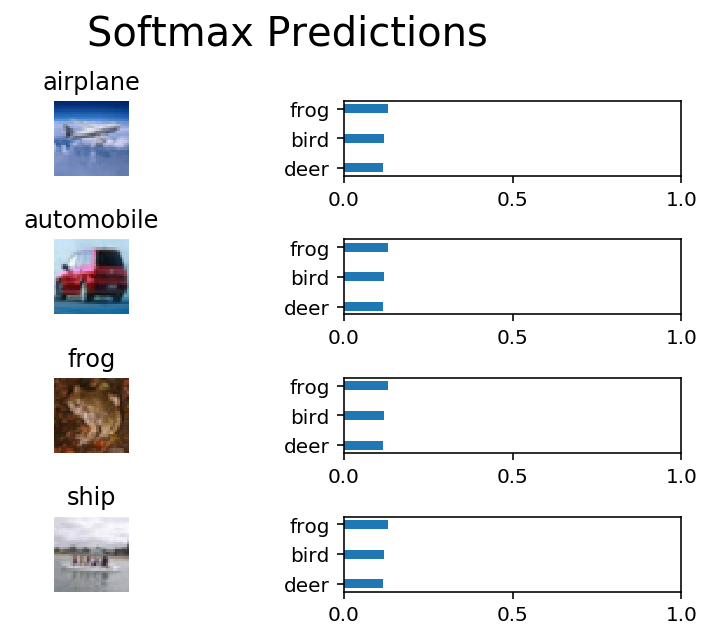

In [78]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Why 50-80% Accuracy?
You might be wondering why you can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. However, you might notice people are getting scores [well above 80%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130).  That's because we haven't taught you all there is to know about neural networks. We still need to cover a few more techniques.
## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook.  Save the notebook file as "dlnd_image_classification.ipynb" and save it as a HTML file under "File" -> "Download as".  Include the "helper.py" and "problem_unittests.py" files in your submission.